<a href="https://colab.research.google.com/github/lmassaron/ml4dummies_3ed/blob/main/ML4D3E_11_leveraging_similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

repository = "https://github.com/lmassaron/"
release = "ml4dummies_3ed/releases/download/v1.0/"
filename = repository + release + "penguins.csv"
penguins = pd.read_csv(filename)

features = penguins.iloc[:,1:5]
le = LabelEncoder()
labels = le.fit_transform(penguins.species)
target_names = dict(zip(range(3), le.classes_))

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans, KMeans

pca_pipeline = Pipeline([("scaler", StandardScaler()),
                         ("pca", PCA())])
pca_features = pca_pipeline.fit_transform(features)
explained_variance = (pca_pipeline.named_steps["pca"]
                         .explained_variance_)
print("Explained variance:", explained_variance)

k_means = KMeans(n_clusters=3, init="k-means++",
            max_iter=999, n_init=10, random_state=101)
mini_kmeans = MiniBatchKMeans(n_clusters=3,
              init="k-means++", max_iter=999, n_init=10,
              batch_size=30, random_state=101)

k_means.fit(pca_features)
mini_kmeans.fit(pca_features)

Explained variance: [2.75362487 0.7804609  0.36975289 0.10820954]


MiniBatchKMeans(batch_size=30, max_iter=999, n_clusters=3, n_init=10,
                random_state=101)

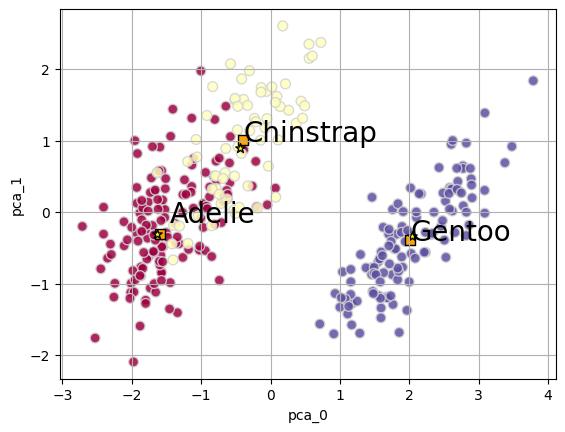

In [3]:
import matplotlib.pyplot as plt

plt.scatter(pca_features[:,0], pca_features[:,1], s=50,
          c=labels, edgecolors="lightgrey", alpha=0.85,
          cmap="Spectral")

plt.xlabel("pca_0")
plt.ylabel("pca_1")
plt.grid()

km_centers = k_means.cluster_centers_
mkm_centers = mini_kmeans.cluster_centers_

plt.scatter(km_centers[:,0], km_centers[:,1],
            s=50, marker="s", c="orange",
            edgecolors="black")
plt.scatter(mkm_centers[:,0], mkm_centers[:,1],
            s=50, marker="*", c="yellow",
            edgecolors="black")

for class_no in range(0,3):
    plt.annotate(target_names[class_no],
          (pca_features[labels==class_no, 0].mean(),
           pca_features[labels==class_no, 1].mean()),
           fontsize=20)
plt.show()

In [4]:
import numpy as np

for iteration in range(1, 10):
    k_means = KMeans(n_clusters=3, init="random",
        max_iter=iteration, n_init=1, random_state=101)
    k_means.fit(pca_features)
    centroid = np.round(k_means.cluster_centers_[1], 3)
    print(f"Iteration: {iteration}", end= " ")
    print(f"- 2nd centroid: {centroid}")

Iteration: 1 - 2nd centroid: [ 0.168 -0.31   0.376  0.007]
Iteration: 2 - 2nd centroid: [ 0.428 -0.096  0.547  0.016]
Iteration: 3 - 2nd centroid: [0.207 0.413 0.616 0.054]
Iteration: 4 - 2nd centroid: [-0.222  1.013  0.661  0.053]
Iteration: 5 - 2nd centroid: [-0.306  1.109  0.616  0.039]
Iteration: 6 - 2nd centroid: [-0.333  1.103  0.599  0.028]
Iteration: 7 - 2nd centroid: [-0.333  1.103  0.599  0.028]
Iteration: 8 - 2nd centroid: [-0.333  1.103  0.599  0.028]
Iteration: 9 - 2nd centroid: [-0.333  1.103  0.599  0.028]


In [5]:
from sklearn.metrics import confusion_matrix

pca = Pipeline([("scaling", StandardScaler()),
              ("pca", PCA())])
pca_features = pca.fit_transform(features)

k_means = KMeans(n_clusters=3, init="k-means++",
              max_iter=999, n_init=10, random_state=101)
k_means.fit(pca_features)

cm = confusion_matrix(y_true=labels,
              y_pred=k_means.labels_)
cm_str = str(cm).split("\n")
for row in range(3):
    print(f"{target_names[row]:15} {cm_str[row]}")

Adelie          [[  0  22 124]
Chinstrap        [  0  63   5]
Gentoo           [119   0   0]]


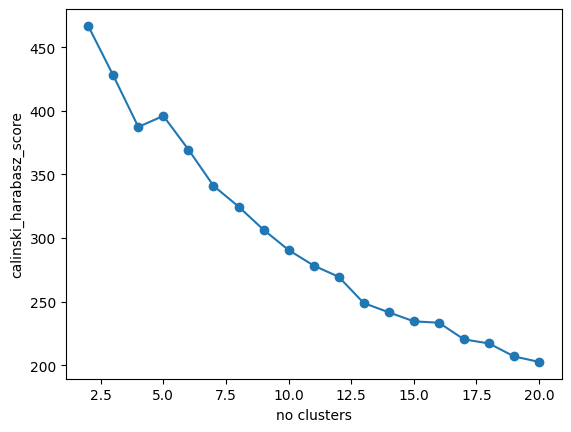

In [6]:
from sklearn.metrics import calinski_harabasz_score

ch_scores = list()
max_clus = 20
for clus_no in range(2, max_clus+1):
    k_means = KMeans(n_clusters=clus_no,
                     init="k-means++", max_iter=999,
                     n_init=10, random_state=101)
    k_means.fit(pca_features)
    ch = calinski_harabasz_score(pca_features,
                                 k_means.labels_)
    ch_scores.append(ch)

plt.plot(range(2, max_clus+1), ch_scores, "o-")
plt.xlabel("no clusters")
plt.ylabel("calinski_harabasz_score")
plt.show()

In [7]:
k_means = KMeans(n_clusters=5, init="k-means++",
              max_iter=999, n_init=10, random_state=101)
k_means.fit(pca_features)

cm = confusion_matrix(y_true=labels,
                      y_pred=k_means.labels_)
for row in range(3):
    print(f"{target_names[row]:10} {cm[row,:]}")

Adelie     [ 0 84  2  0 60]
Chinstrap  [ 0  5 63  0  0]
Gentoo     [62  0  0 57  0]


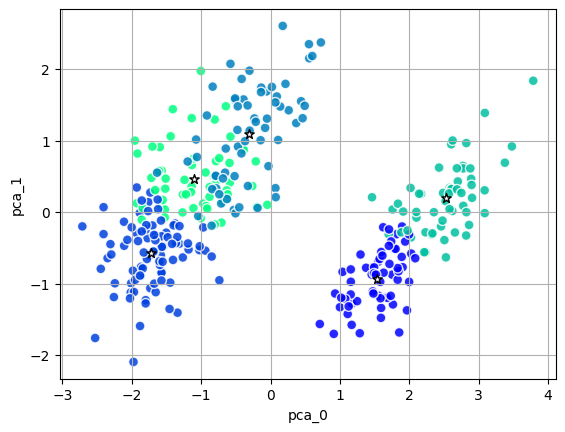

In [8]:
plt.scatter(pca_features[:,0], pca_features[:,1],
          s=50, c=k_means.labels_,
          edgecolors="white", alpha=0.85, cmap="winter")

km_centers = k_means.cluster_centers_
plt.scatter(km_centers[:,0], km_centers[:,1],
      s=50, marker="*", c="white", edgecolors="black")

plt.xlabel("pca_0")
plt.ylabel("pca_1")
plt.grid()
plt.show()

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

knn = KNeighborsClassifier(metric="euclidean")
kfold = KFold(n_splits=10, shuffle=True,
              random_state=0)
param_grid = {"n_neighbors": range(1, 16)}

experiment = GridSearchCV(knn, param_grid=param_grid,
                          cv=kfold)

In [10]:
experiment.fit(features, labels)
print(f"best params: {experiment.best_params_}")
print(f"best cv accuracy: {experiment.best_score_:.3}")

best params: {'n_neighbors': 1}
best cv accuracy: 0.859


In [11]:
experiment.fit(pca_features, labels)
print(f"best params: {experiment.best_params_}")
print(f"best cv acc: {experiment.best_score_:.3}")

best params: {'n_neighbors': 3}
best cv acc: 0.991


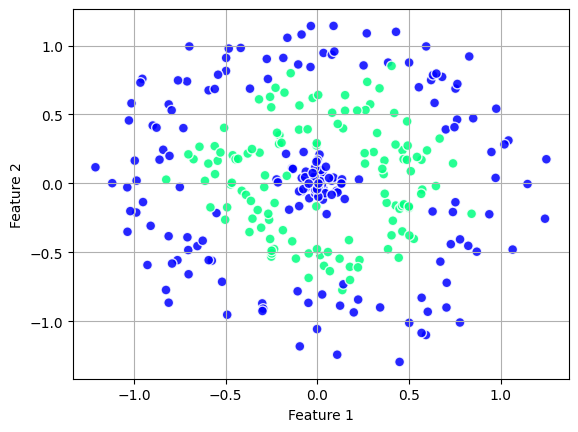

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles, make_blobs
from sklearn.model_selection import train_test_split

X_circles, y_circles = make_circles(n_samples=500,
                          shuffle=True, noise=0.15,
                          random_state=101, factor=0.5)
X_blob, y_blob_generated = make_blobs(n_samples=100,
                              n_features=2, centers=1,
                              cluster_std=0.1,
                              center_box=(0, 0))

y_blob = np.zeros(100, dtype=int)
X_combined = np.vstack((X_circles, X_blob))
y_combined = np.concatenate((y_circles, y_blob))
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y_combined, test_size=0.5,
    shuffle=True, stratify=y_combined, random_state=101)

plt.scatter(X_train[:, 0], X_train[:, 1], s=50,
            c=y_train, edgecolors="white",
            alpha=0.85, cmap="winter")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid()
plt.show()

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

kNN = KNeighborsClassifier(n_neighbors=3,
                           weights="uniform",
                           algorithm="auto",
                           metric="euclidean")

kNN.fit(X_train, y_train)
preds = kNN.predict(X_test)
acc = accuracy_score(y_true=y_test, y_pred=preds)

print(f"Learning accuracy score: {acc:0.3}")

Learning accuracy score: 0.93
